In [ ]:
# Install required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import libraries for downloading the dataset
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/punfake/resisc45'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'resisc45/NWPU-RESISC45'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (128, 128))
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(lb.classes_)

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Compile and train the student model using distillation loss with Adam optimizer
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

# Define alpha values for experiments
alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.title("Alpha vs F1-Score")
plt.xlabel("Alpha")
plt.ylabel("F1-Score")
plt.grid(True)

# Plot Accuracy vs. Alpha
plt.subplot(2, 2, 2)
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.title("Alpha vs Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot Precision vs. Alpha
plt.subplot(2, 2, 3)
plt.plot(alpha_values, precisions, marker='o', color='orange')
plt.title("Alpha vs Precision")
plt.xlabel("Alpha")
plt.ylabel("Precision")
plt.grid(True)

# Plot Recall vs. Alpha
plt.subplot(2, 2, 4)
plt.plot(alpha_values, recalls, marker='o', color='red')
plt.title("Alpha vs Recall")
plt.xlabel("Alpha")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha separately
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, inference_times, marker='o', color='purple')
plt.title("Alpha vs Inference Time")
plt.xlabel("Alpha")
plt.ylabel("Inference Time (seconds)")
plt.grid(True)
plt.show()


Skipping, found downloaded files in "./resisc45" (use force=True to force download)


In [3]:
# Install required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import libraries for downloading the dataset
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/punfake/resisc45'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'resisc45/NWPU-RESISC45'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))  # Resize
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# # Compile and train the student model using distillation loss with Adam optimizer
# student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
# student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# # Evaluate models
# teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
# student_score = student.evaluate(x_test, y_test, verbose=0)
# print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
# print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

# # Define alpha values for experiments
# alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
# f1_scores = []
# accuracies = []
# precisions = []
# recalls = []
# inference_times = []

# # Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
# def evaluate_student_with_alpha(alpha):
#     # Redefine distillation loss function with current alpha
#     def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
#         teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
#         y_true = tf.keras.activations.softmax(y_true / temperature)
#         y_pred = tf.keras.activations.softmax(y_pred / temperature)
#         teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
#         soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
#         hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#         return alpha * soft_loss + (1. - alpha) * hard_loss

#     # Compile the student model with the new distillation loss
#     student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                     loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
#                     metrics=['accuracy'])

#     # Train the student model
#     student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
#                 callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

#     # Predict and evaluate
#     start_time = time.time()
#     y_pred_probs = student.predict(x_test)
#     inference_time = time.time() - start_time
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)

#     # Calculate and store F1-score, accuracy, precision, recall, and inference time
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     acc = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Append the results
#     f1_scores.append(f1)
#     accuracies.append(acc)
#     precisions.append(precision)
#     recalls.append(recall)
#     inference_times.append(inference_time)

#     # Print classification report
#     print(f"=== Classification Report for Alpha: {alpha} ===")
#     print(classification_report(y_true, y_pred, target_names=lb.classes_))
#     print(f"Inference Time: {inference_time:.4f} seconds\n")
#     print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# # Run evaluation for each alpha
# for alpha in alpha_values:
#     evaluate_student_with_alpha(alpha)

# # Plot F1-Score vs. Alpha
# plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# plt.plot(alpha_values, f1_scores, marker='o', color='b')
# plt.title("Alpha vs F1-Score")
# plt.xlabel("Alpha")
# plt.ylabel("F1-Score")
# plt.grid(True)

# # Plot Accuracy vs. Alpha
# plt.subplot(2, 2, 2)
# plt.plot(alpha_values, accuracies, marker='o', color='g')
# plt.title("Alpha vs Accuracy")
# plt.xlabel("Alpha")
# plt.ylabel("Accuracy")
# plt.grid(True)

# # Plot Precision vs. Alpha
# plt.subplot(2, 2, 3)
# plt.plot(alpha_values, precisions, marker='o', color='orange')
# plt.title("Alpha vs Precision")
# plt.xlabel("Alpha")
# plt.ylabel("Precision")
# plt.grid(True)

# # Plot Recall vs. Alpha
# plt.subplot(2, 2, 4)
# plt.plot(alpha_values, recalls, marker='o', color='red')
# plt.title("Alpha vs Recall")
# plt.xlabel("Alpha")
# plt.ylabel("Recall")
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# # Plot Inference Time vs. Alpha separately
# plt.figure(figsize=(7, 5))
# plt.plot(alpha_values, inference_times, marker='o', color='purple')
# plt.title("Alpha vs Inference Time")
# plt.xlabel("Alpha")
# plt.ylabel("Inference Time (seconds)")
# plt.grid(True)
# plt.show()

Skipping, found downloaded files in "./resisc45" (use force=True to force download)
Training samples: 25200, Testing samples: 6300
Epoch 1/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 284s 359ms/step - accuracy: 0.0499 - loss: 3.6619 - val_accuracy: 0.1414 - val_loss: 3.2113 - learning_rate: 0.0100
Epoch 2/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 323s 360ms/step - accuracy: 0.1753 - loss: 3.0042 - val_accuracy: 0.2524 - val_loss: 2.5981 - learning_rate: 0.0100
Epoch 3/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 321s 360ms/step - accuracy: 0.2833 - loss: 2.5439 - val_accuracy: 0.3263 - val_loss: 2.3848 - learning_rate: 0.0100
Epoch 4/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 286s 362ms/step - accuracy: 0.3521 - loss: 2.2358 - val_accuracy: 0.4289 - val_loss: 1.9586 - learning_rate: 0.0100
Epoch 5/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 277s 352ms/step - accuracy: 0.4403 - loss: 1.9052 - val_accuracy: 0.4689 - val_loss: 1.8307 - learning_rate: 0.0100
Epoch 6/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 321s 351ms/step - accuracy: 0.5131 - loss: 1.6518 - val

KeyboardInterrupt: 

In [4]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
#student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 60.11%


Epoch 1/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 73s 85ms/step - accuracy: 0.6337 - loss: 3.8060 - val_accuracy: 0.5725 - val_loss: 3.8061 - learning_rate: 0.0010
Epoch 2/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.6326 - loss: 3.8060 - val_accuracy: 0.5678 - val_loss: 3.8061 - learning_rate: 0.0010
Epoch 3/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.6481 - loss: 3.8060 - val_accuracy: 0.5538 - val_loss: 3.8062 - learning_rate: 0.0010
Epoch 4/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.6637 - loss: 3.8060 - val_accuracy: 0.5692 - val_loss: 3.8062 - learning_rate: 0.0010
Epoch 5/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.6754 - loss: 3.8060 - val_accuracy: 0.5713 - val_loss: 3.8061 - learning_rate: 0.0010
Epoch 6/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.6885 - loss: 3.8060 - val_accuracy: 0.5737 - val_loss: 3.8061 - learning_rate: 0.0010
Epoch 7/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.7048 - l

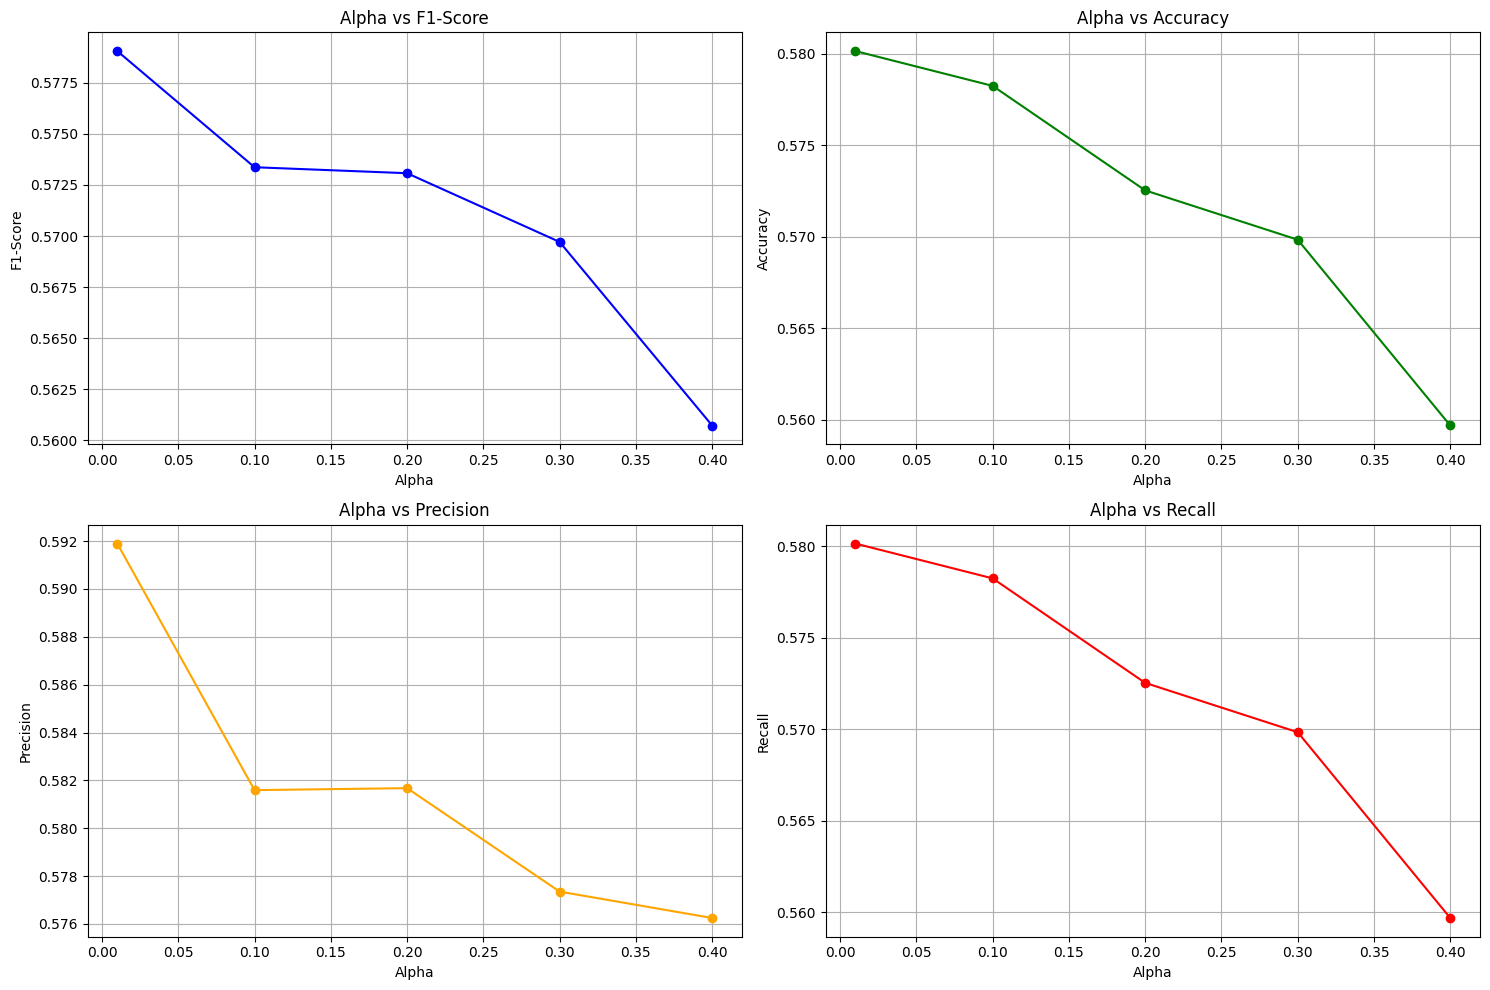

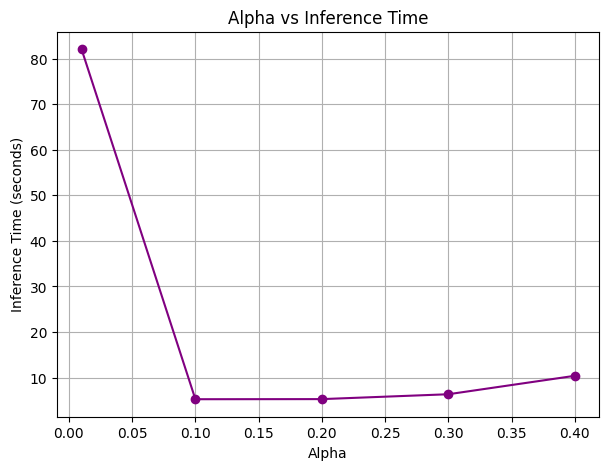

In [5]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

# Define alpha values for experiments
alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.title("Alpha vs F1-Score")
plt.xlabel("Alpha")
plt.ylabel("F1-Score")
plt.grid(True)

# Plot Accuracy vs. Alpha
plt.subplot(2, 2, 2)
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.title("Alpha vs Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot Precision vs. Alpha
plt.subplot(2, 2, 3)
plt.plot(alpha_values, precisions, marker='o', color='orange')
plt.title("Alpha vs Precision")
plt.xlabel("Alpha")
plt.ylabel("Precision")
plt.grid(True)

# Plot Recall vs. Alpha
plt.subplot(2, 2, 4)
plt.plot(alpha_values, recalls, marker='o', color='red')
plt.title("Alpha vs Recall")
plt.xlabel("Alpha")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha separately
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, inference_times, marker='o', color='purple')
plt.title("Alpha vs Inference Time")
plt.xlabel("Alpha")
plt.ylabel("Inference Time (seconds)")
plt.grid(True)
plt.show()